In [1]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [2]:
nteams = 20
nmatches = (nteams-1)*2

In [3]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

Data Pre-processing

In [90]:
def season_team_map(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        print(s)
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    print(team_map)
    return team_map

In [67]:
def season_team_map_div_2(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "
            
    s = f.readline()
    if(len(s)<=1):
        s = "  "    
        
     # skip to div 2 teams
    while(s[:3] != ' 1.'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    print(team_map)
    return team_map

In [91]:
def season_game_mat(season_dir, team_map, div=1):
    game_mat = np.zeros((nteams, nmatches), dtype=int)
    team_index = np.zeros(nteams, dtype=int)

    csvfile = ''
    print(div)
    
    for entry in os.scandir(season_dir):
        if(div==1):
            if '/1-' in entry.path:
                csvfile = entry.path
        elif(div==2):
            if '/2-' in entry.path:
                csvfile = entry.path
            
    with open(csvfile) as gf:
        reader = csv.reader(gf)
        header = next(reader)
        if(header[0] == 'Round'):
            new_format = 1
        else:
            new_format = 0;
        for row in reader:
            if(new_format):
                team1 = team_map[row[2].split(' (')[0]]
                team2 = team_map[row[5].split(' (')[0]]

                score = row[3].split('-')
            else:
                team1 = team_map[row[1]]
                team2 = team_map[row[2]]

                score = row[3].split('-')
            

            # 1 for win, 0 for draw, -1 for loss

            if(int(score[0]) > int(score[1])):
                game_mat[team1, team_index[team1]] = 1
                game_mat[team2, team_index[team2]] = -1
            elif(int(score[0]) < int(score[1])):
                game_mat[team1, team_index[team1]] = -1
                game_mat[team2, team_index[team2]] = 1

            team_index[team1] += 1
            team_index[team2] += 1
    
    return np.transpose(game_mat)

In [92]:
country_dirs = []
season_dirs = []

nseasons = 0
team_maps = []
game_mats = []

for entry in os.scandir('./data'):
    if entry.is_dir():
        country_dirs.append(entry.path)

for cdir in country_dirs:
#     print(cdir)
    for entry in os.scandir(cdir):
#         print(entry.name)
        if entry.is_dir():
            season_dir = entry.path
            team_maps.append(season_team_map(season_dir))
            game_mats.append(season_game_mat(season_dir, team_maps[nseasons]))
            nseasons += 1
            if(cdir=='./data/fr-france-master' and int(entry.name.split('-')[0])>=2002):
                team_maps.append(season_team_map_div_2(season_dir))
                game_mats.append(season_game_mat(season_dir, team_maps[nseasons], div=2))
                nseasons += 1

./data/fr-france-master
2017-18




### Standings





```

                                        - Home -          - Away -            - Total -

                                 Pld   W  D  L   F:A     W  D  L   F:A      F:A   +/-  Pts

 1. Paris Saint-Germain           38  17  1  1  70:15   12  5  2  38:14   108:29  +79   93

{'Paris Saint-Germain': 0, 'AS Monaco': 1, 'Olympique Lyonnais': 2, 'Olympique de Marseille': 3, 'Stade Rennais FC': 4, 'Girondins de Bordeaux': 5, 'AS Saint-Étienne': 6, 'OGC Nice': 7, 'FC Nantes': 8, 'Montpellier HSC': 9, 'Dijon FCO': 10, 'EA Guingamp': 11, 'Amiens SC': 12, 'Angers SCO': 13, 'RC Strasbourg': 14, 'Stade Malherbe Caen': 15, 'Lille OSC': 16, 'Toulouse FC': 17, 'ES Troyes AC': 18, 'FC Metz': 19}
1
{'Stade de Reims': 0, 'Nîmes Olympique': 1, 'AC Ajaccio': 2, 'Le Havre AC': 3, 'Stade Brestois 29': 4, 'Clermont Foot 63': 5, 'FC Lorient': 6, 'Paris FC': 7, 'LB Châteauroux': 8, 'FC Sochaux-Montbéliard': 9, 'AJ Auxerre': 10, 'US Orléans': 11, 'Valenc

2
2015-16




### Standings





```

                                        - Home -          - Away -            - Total -

                                 Pld   W  D  L   F:A     W  D  L   F:A      F:A   +/-  Pts

 1. Paris Saint-Germain           38  15  3  1  59:12   15  3  1  43:7    102:19  +83   96

{'Paris Saint-Germain': 0, 'Olympique Lyonnais': 1, 'AS Monaco': 2, 'OGC Nice': 3, 'Lille OSC': 4, 'AS Saint-Étienne': 5, 'Stade Malherbe Caen': 6, 'Stade Rennais FC': 7, 'Angers SCO': 8, 'SC Bastia': 9, 'Girondins de Bordeaux': 10, 'Montpellier HSC': 11, 'Olympique de Marseille': 12, 'FC Nantes': 13, 'FC Lorient': 14, 'EA Guingamp': 15, 'Toulouse FC': 16, 'Stade de Reims': 17, 'GFC Ajaccio': 18, 'ES Troyes AC': 19}
1
{'AS Nancy Lorraine': 0, 'Dijon FCO': 1, 'FC Metz': 2, 'Le Havre AC': 3, 'Red Star FC': 4, 'RC Lens': 5, 'Clermont Foot 63': 6, 'AJ Auxerre': 7, 'Nîmes Olympique': 8, 'Tours FC': 9, 'Stade Brestois 29': 10, 'Bourg-en-Bresse 01': 11, 'Valenciennes FC': 12, 'Stade Lava

In [93]:
nseasons

88

In [36]:
def eucl_error(outputs, targets):
    return np.mean(np.abs(targets - outputs))

In [37]:
def disc_error(outputs, targets):
    rounded_outputs = np.round(outputs)
    err = 0
    n = 0
    for i in range(len(outputs)):
        for j in range(len(outputs[i])):
            if(int(rounded_outputs[i][j]) != int(targets[i][j])):
                err += 1
            n += 1
    return float(err)/n

In [99]:
ntraining = int(nseasons*0.7)
ntesting = nseasons - ntraining

training_game_mats = game_mats[:ntraining]
testing_game_mats = game_mats[ntesting:]

X_training = np.reshape(np.array(training_game_mats), (ntraining*nmatches, nteams))
lengths = np.full(ntraining, nmatches)

In [101]:
X_trainings = []
Y_trainings = []
for i in range(1, nmatches):
    X_training = []
    Y_training = []
    for game_mat in training_game_mats:
        for j in range(nmatches-i):
            X_training.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_training.append(game_mat[j+i])
    
    X_training = np.array(X_training).reshape(-1,i,nteams)
    Y_training = np.array(Y_training).reshape(-1,nteams)
    X_trainings.append(X_training)
    Y_trainings.append(Y_training)

In [102]:
X_testings = []
Y_testings = []
for i in range(1, nmatches):
    X_testing = []
    Y_testing = []
    for game_mat in testing_game_mats:
        for j in range(nmatches-i):
            X_testing.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_testing.append(game_mat[j+i])
            
    X_testing = np.array(X_testing).reshape(-1,i,nteams)
    Y_testing = np.array(Y_testing).reshape(-1,nteams)
    X_testings.append(X_testing)
    Y_testings.append(Y_testing)

In [122]:
# layer_sizes = [30, 50, 100, 200]
layer_sizes = [200]

In [123]:
rnns = {}
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    rnns[key] = []

In [124]:
rnns

{'200_neuron_layers': []}

In [125]:
histories = {}
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    histories[key] = []

In [146]:
epochs = 20
max_sequence_length = 10

In [147]:
for i in range(max_sequence_length):
    print("Sequence Length of " + str(i))
    for size in layer_sizes:
        print("Layer size " + str(size))
        key = str(size)+'_neuron_layers'       
        # define the LSTM model
        model = Sequential()
        model.add(LSTM(size, input_shape=(i+1, nteams)))
        model.add(Dropout(0.2))
        #model.add(Dense(nteams, activation='softmax'))
        model.add(Dense(nteams, activation='tanh'))
        #model.compile(loss='categorical_crossentropy', optimizer='adam')
        model.compile(loss='mean_squared_error', optimizer='adam')
        histories[key].append(model.fit(X_trainings[i], np.array(Y_trainings[i]), epochs=epochs))
        rnns[key].append(model)

Sequence Length of 0
Layer size 200
Epoch 1/20
2257/2257 [==============================] - 4s 2ms/step - loss: 0.6878
Epoch 2/20
2257/2257 [==============================] - 1s 268us/step - loss: 0.6645
Epoch 3/20
2257/2257 [==============================] - 1s 241us/step - loss: 0.6601
Epoch 4/20
2257/2257 [==============================] - 1s 246us/step - loss: 0.6575
Epoch 5/20
2257/2257 [==============================] - 1s 249us/step - loss: 0.6558
Epoch 6/20
2257/2257 [==============================] - 1s 257us/step - loss: 0.6547
Epoch 7/20
2257/2257 [==============================] - 1s 281us/step - loss: 0.6536
Epoch 8/20
2257/2257 [==============================] - 1s 288us/step - loss: 0.6529
Epoch 9/20
2257/2257 [==============================] - 1s 269us/step - loss: 0.6525
Epoch 10/20
2257/2257 [==============================] - 1s 258us/step - loss: 0.6513
Epoch 11/20
2257/2257 [==============================] - 1s 259us/step - loss: 0.6504
Epoch 12/20
2257/2257 [======

2013/2013 [==============================] - 1s 475us/step - loss: 0.6002
Epoch 15/20
2013/2013 [==============================] - 1s 461us/step - loss: 0.5871
Epoch 16/20
2013/2013 [==============================] - 1s 461us/step - loss: 0.5724
Epoch 17/20
2013/2013 [==============================] - 1s 592us/step - loss: 0.5539
Epoch 18/20
2013/2013 [==============================] - 1s 450us/step - loss: 0.5381
Epoch 19/20
2013/2013 [==============================] - 1s 435us/step - loss: 0.5206
Epoch 20/20
2013/2013 [==============================] - 1s 440us/step - loss: 0.4957
Sequence Length of 5
Layer size 200
Epoch 1/20
1952/1952 [==============================] - 5s 3ms/step - loss: 0.6757
Epoch 2/20
1952/1952 [==============================] - 1s 495us/step - loss: 0.6601
Epoch 3/20
1952/1952 [==============================] - 1s 440us/step - loss: 0.6540
Epoch 4/20
1952/1952 [==============================] - 1s 443us/step - loss: 0.6516
Epoch 5/20
1952/1952 [==============

1708/1708 [==============================] - 1s 659us/step - loss: 0.6400
Epoch 8/20
1708/1708 [==============================] - 1s 635us/step - loss: 0.6359
Epoch 9/20
1708/1708 [==============================] - 1s 635us/step - loss: 0.6306
Epoch 10/20
1708/1708 [==============================] - 1s 705us/step - loss: 0.6250
Epoch 11/20
1708/1708 [==============================] - 1s 622us/step - loss: 0.6171
Epoch 12/20
1708/1708 [==============================] - 1s 621us/step - loss: 0.6066 0s
Epoch 13/20
1708/1708 [==============================] - 1s 657us/step - loss: 0.5944
Epoch 14/20
1708/1708 [==============================] - 1s 730us/step - loss: 0.5832
Epoch 15/20
1708/1708 [==============================] - 1s 621us/step - loss: 0.5671 0s
Epoch 16/20
1708/1708 [==============================] - 1s 613us/step - loss: 0.5507
Epoch 17/20
1708/1708 [==============================] - 1s 617us/step - loss: 0.5298
Epoch 18/20
1708/1708 [==============================] - 1s 62

In [154]:
del histories['200_neuron_layers'][:10]

In [155]:
histories

{'200_neuron_layers': [<keras.callbacks.History at 0x1a5866ac88>,
  <keras.callbacks.History at 0x1a63ab2c88>]}

In [156]:
histories['200_neuron_layers'][0].history

{'loss': [0.68784040405415414,
  0.66445436784531298,
  0.66005649181610193,
  0.65749570662646784,
  0.65578104974846418,
  0.6546577947510519,
  0.65359442567846449,
  0.65292801387446298,
  0.65249176399339126,
  0.65128319658005618,
  0.65035874393591586,
  0.64926546856952438,
  0.64824505532585419,
  0.64770746880735397,
  0.64588524228870525,
  0.64485777438505598,
  0.64390761972688493,
  0.64238836219155482,
  0.64096725581227865,
  0.6395478477032247]}

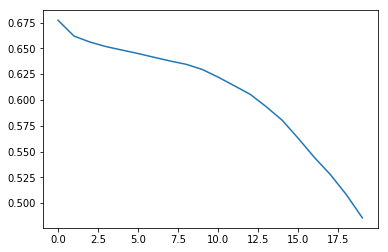

In [157]:
plt.plot(histories['200_neuron_layers'][7].history['loss'])
plt.show()

In [158]:
def score(key):
    training_accs = []
    training_errs = []

    print(key)
    with open('rnn_training_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("training")
        for i in range(max_sequence_length):
            print(i)
            outputs = rnns[key][i].predict(X_trainings[i])
            acc = 1 - disc_error(outputs, np.array(Y_trainings[i]))
            eerr = eucl_error(outputs, np.array(Y_trainings[i]))

            writer.writerow([i, acc, eerr])
            training_accs.append(acc)
            training_errs.append(eerr)
            
    testing_accs = []
    testing_errs = []

    with open('rnn_testing_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("testing")
        for i in range(max_sequence_length):
            print(i)
            outputs = rnns[key][i].predict(X_testings[i])
            acc = 1 - disc_error(outputs, np.array(Y_testings[i]))
            eerr = eucl_error(outputs, np.array(Y_testings[i]))

            writer.writerow([i, acc, eerr])
            testing_accs.append(acc)
            testing_errs.append(eerr)
    
    training_accs_dict[key] = training_accs
    training_errs_dict[key] = training_errs
    testing_accs_dict[key] = testing_accs
    testing_errs_dict[key] = testing_errs

In [159]:
training_accs_dict = {}
training_errs_dict = {}
testing_accs_dict = {}
testing_errs_dict = {}

In [160]:
training_errs_dict

{}

In [161]:
for size in layer_sizes:
    print(size)
    key = str(size)+'_neuron_layers'
    score(key)

200
200_neuron_layers
training
0
1
2
3
4
5
6
7
8
9
testing
0
1
2
3
4
5
6
7
8
9


In [162]:
def plot(y, ylabel, title, imname):
    x = range(1,max_sequence_length+1)
    yfit = np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
    r2 = np.round(r2_score(y, yfit),decimals=2)
    mean = np.round(np.mean(y), decimals=2)

    plt.scatter(x, y, s = 5)
    plt.plot(x, yfit)
    plt.axis([0,max_sequence_length+1,0,1])
    plt.text(1, 0.95, 'R^2: ' + str(r2))
    plt.text(1, 0.85, 'Mean: ' + str(mean))
    plt.xlabel('Games before prediction')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('rnnplots/' + imname + '.png')
    plt.show()

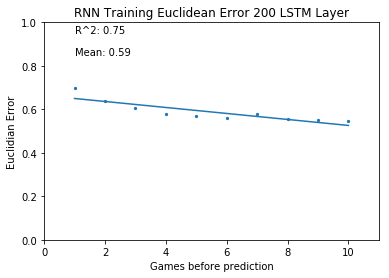

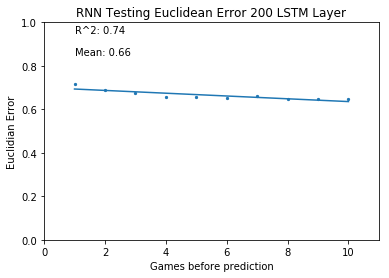

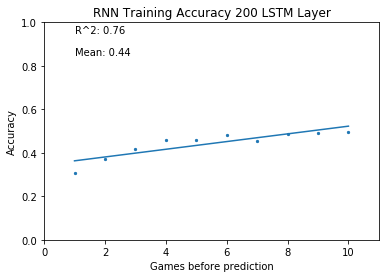

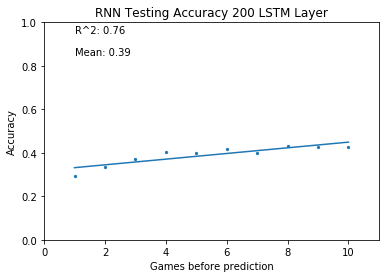

In [163]:
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    title = ' ' + str(size) + ' LSTM Layer'
    plot(training_errs_dict[key], 'Euclidian Error', 'RNN Training Euclidean Error' + title, 'rnn_training_error_plot_'+key)
    plot(testing_errs_dict[key], 'Euclidian Error', 'RNN Testing Euclidean Error' + title, 'rnn_testing_error_plot_'+key)
    plot(training_accs_dict[key], 'Accuracy', 'RNN Training Accuracy' + title, 'rnn_training_accuracy_plot_'+key)
    plot(testing_accs_dict[key], 'Accuracy', 'RNN Testing Accuracy' + title, 'rnn_testing_accuracy_plot_'+key)